<a name="top"></a><a id="top">
# [Creating TFRecords](https://keras.io/examples/keras_recipes/creating_tfrecords/)
   
<a href="https://colab.research.google.com/github/gbih/ml-notes/blob/main/tf_record_tftrain/nb_004_tfrecords_images.ipynb">
<strong>View in Colab</strong>
</a>
    
---
Original author: [Dimitre Oliveira](https://www.linkedin.com/in/dimitre-oliveira-7a1a0113a/)

1. [Setup](#setup)
2. [Introduction](#2.0)
3. [Download the COCO2017 dataset](#3.0)

---
<a id="setup"></a><a name="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [1]:
!rm -fr tfrecords_coco

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint as pp
import tensorflow as tf

# To make this notebook's output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

def HR():
    print("-"*40)
    
print("Libraries loaded..")

Libraries loaded..


---
<a id="2.0"></a><a name="2.0"></a>
# 2. Introduction
<a href="#top">[back to top]</a>

The TFRecord is a simple format for storing a sequence of binary records. Converting data to TFRecords has the advantages of:

* More efficient storage: TFRecord data can take up less space than the original data, and can also be partitioned into multiple files.

* Fast I/O: the TFRecord format can be read with parallel I/O operations, which is useful for TPUs or multiple hosts.

* Self-contained files: TFRecord data can be organized to be read from a single source. For example, the COCO2017 dataset originally stores data in two folders ("images" and "annotations").

An important use case of the TFRecord data format is training on TPUs. TPUs are fast enough to benefit from optimized I/O operations. Also, TPUs require data to be stored remotely (eg on Google Cloud Storage) and using TFRecord format makes it easier to load data without batch-downloading.

Performance with TFRecord can be further improved if it is used with the tf.data API.

<a id="3.0"></a><a name="3.0"></a>
# 3. Download the COCO2017 dataset
<a href="#top">[back to top]</a>

The [COCO2017 dataset](https://cocodataset.org/#home) it used as it has many different types of features, including images, floating point data, and lists. It will serve as a good example of how to encode different features into the TFRecord format.

We are actually using only the validation-dataset

This dataset has two sets of fields: images and annotation meta-data.

The images are a collection of JPG files. 

The metadata are stored in a JSON file which contains the following properties:

```
id: int,
image_id: int,
category_id: int,
segmentation: RLE or [polygon], object segmentation mask
bbox: [x,y,width,height], object bounding box coordinates
area: float, area of the bounding box
iscrowd: 0 or 1, is single object or a collection
```

In [3]:
root_dir = "datasets"
tfrecords_dir = "tfrecords_coco"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "image.zip",
        cache_dir=os.path.abspath("."),
        origin=images_url,
        extract=True,
    )
    os.remove(image_zip)
    
# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=annotations_url,
        extract=True
    )
    os.remove(annotation_zip)
    
print("The COCO dataset has been downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]
    
print(f"Number of images: {len(annotations):,}")

252919808/252907541 [==============================] - 3s 0us/step
The COCO dataset has been downloaded and extracted successfully.
Number of images: 36,781


In [4]:
!du -h {root_dir}

796M	datasets/annotations
788M	datasets/val2017
1.6G	datasets


## Contents of COCO2017 dataset

In [5]:
pp.pprint(annotations[60])

{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


## Parameters

`num_samples` is the number of data samples of each TFRecord file.

`num_tfrecords` is the total number of TFRecords that we will create.

In [6]:
# num_samples = 4096 # Arbitrary number, we could set to 10 or 10000
# #num_samples = 100

# print(f"len of annotations: {len(annotations)}")
# HR()

# num_tfrecords = len(annotations) // num_samples
# print(f"num_tfrecords: {num_tfrecords}")
# HR()

# if len(annotations) % num_samples:
#     print("There is a remaining sample")
#     # Add a record if there are any remaining samples
#     num_tfrecords += 1 
#     print(f"num_tfrecords increased to {num_tfrecords}")
    
    
if not os.path.exists(tfrecords_dir):
    # Create TFRecords output folder
    os.makedirs(tfrecords_dir)
    print("Creating TFRecords output folder")

# with num_samples = 4096,
# len of annotations: 36781
# ----------------------------------------
# num_tfrecords: 8
# ----------------------------------------
# There is a remaining sample
# num_tfrecords increased to 9


# with num_samples = 100,
# len of annotations: 36781
# ----------------------------------------
# num_tfrecords: 367
# ----------------------------------------
# There is a remaining sample
# num_tfrecords increased to 368

Creating TFRecords output folder


## Define TFRecords helper functions

We use the these utilities to convert a standard TensorFlow type to a `tf.train.Example`-compatible `tf.train.Feature`. 

Except for `float_feature_list()`, the functions take a scalar input value and returns a `tf.train.Feature`, containing the appropriate types.




In [7]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    # THIS DOES NOT SEEM TO WORK
    # if isinstance(value, type(tf.constant(0))):
    #     value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string/byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(
            # Do we really need to use encode here?
            value=[value.encode()]
        )
    )

def float_feature(value):
    """Returns a float_list from a float/double."""
    return tf.train.Feature(
        float_list=tf.train.FloatList(
            value=[value]
        )
    )

def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint"""
    return tf.train.Feature(
        int64_list=tf.train.Int64List(
            value=[value]
        )
    )
    
# This is the only function that can handle a list here as-is, w/o serializing to binary-string
def float_feature_list(value):
    """Returns a list of float_list from a float/double."""
    return tf.train.Feature(
        float_list=tf.train.FloatList(
            # Note we don't wrap with an array, but pass through as-is
            value=value
        )
    )
    
# Reference sample
# {'area': 367.89710000000014,
#  'bbox': [265.67, 222.31, 26.48, 14.71],
#  'category_id': 72,
#  'id': 34096,
#  'image': ....
#  'image_id': 525083,
#  'iscrowd': 0,
#  'segmentation': [[267.51, 222.31, 237.02]]}


#　Create a tf.train.Example message
# What does `example["area"]` come from??
def create_example(image, path, example):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"])
    }
    # Contains the mapping from keys to Feature
    return tf.train.Example(
        # Contains the mapping from keys to Feature
        features=tf.train.Features(feature=feature)
    )


# tf.io.FixedLenFeature: Configuration for parsing a fixed-length input feature.
# tf.io.VarLenFeature: Configuration for parsing a variable-length input feature.
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    
    # Parses a single Example proto
    example = tf.io.parse_single_example(
        example, 
        feature_description
    )
    
    # Decode a JPEG-encoded image to a uint8 tensor
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    
    # Converts a SparseTensor into a dense tensor
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    
    return example

## Generate data in the TFRecord format

Generate the COCO2017 data in the TFRecord format. This will be `file_{number}.tfrec`.

This is optional, but including the number sequences in the filenames can make counting easier.

Since processing files can take a long time, we use tqdm to provide a progress-bar for better UX.

In [8]:
# Resize for quicker processing
DEBUG = True

if DEBUG:
    annotations_n = len(annotations) // 15
    num_samples = 400 # Arbitrary number, we could set to 10 or 10000
else:
    annotations_n = len(annotations)
    num_samples = 4096
    
print(f"len of annotations: {annotations_n}")
HR()

num_tfrecords = annotations_n // num_samples
print(f"num_tfrecords: {num_tfrecords}")
HR()

if annotations_n % num_samples:
    print("There is a remaining sample to add.")
    # Add a record if there are any remaining samples
    num_tfrecords += 1
    print(f"num_tfrecords: {num_tfrecords}")

len of annotations: 2452
----------------------------------------
num_tfrecords: 6
----------------------------------------
There is a remaining sample to add.
num_tfrecords: 7


In [9]:
from tqdm import tqdm
print(f"Processing {num_tfrecords} records.")
HR()

for tfrec_num in tqdm(range(num_tfrecords), position=0, leave=False):
    slice_start = tfrec_num * num_samples
    slice_end = (tfrec_num + 1) * num_samples

    # Assuming this value (num_samples = 4096),
    # slice dynamically to create annotations[0:4096], annotations[4096:8192], etc
    samples = annotations[slice_start : slice_end]

    with tf.io.TFRecordWriter(        
        # len(samples): number of samples per file
        f"{tfrecords_dir}/file_{tfrec_num:02}-{len(samples):01}.tfrec"
    ) as writer:
        for sample in tqdm(samples, desc = f"record {tfrec_num+1} [{slice_start}:{slice_end}]", position=0, leave=True):
            image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
            image = tf.io.decode_jpeg(tf.io.read_file(image_path))
            example = create_example(image, image_path, sample)
            writer.write(example.SerializeToString())

HR()
print("Done transforming the COCO2017 data into TRecord format.")

Processing 7 records.
----------------------------------------


record 7 [2400:2800]: 100%|██████████| 400/400 [00:02<00:00, 135.58it/s]
                                             

----------------------------------------
Done transforming the COCO2017 data into TRecord format.


## Explore one sample from the generated TFRecord

single_file: tfrecords_coco/file_00-400.tfrec
----------------------------------------
bbox                : [473.07 395.93  38.65  28.67]
area                : 702.1057739257812
category_id         : 18
id                  : 1768
image_id            : 289343
path                : b'datasets/val2017/000000289343.jpg'
Image shape         : (640, 529, 3)


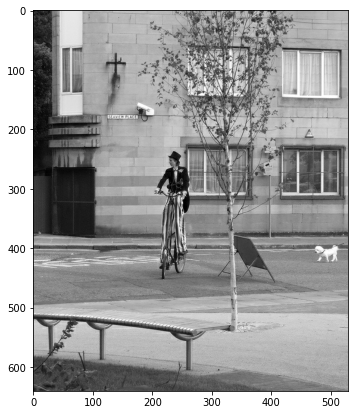

In [10]:
single_file = f"{tfrecords_dir}/file_00-{num_samples}.tfrec"
print(f"single_file: {single_file}")
HR()

raw_dataset = tf.data.TFRecordDataset(single_file)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
img_title = "Image shape"

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key:<20}: {features[key]}")
            
    print(f"{img_title:<20}: {features['image'].shape}")
    plt.figure(figsize=(7,7))
    plt.imshow(features["image"].numpy())
    plt.show()

## Train a simple model using the generated TFRecords

Another advantage of TFRecord is that you are able to add many features to it, and later use only a few of them.

Here, we will only use `image` and `category_id`.

## Define dataset helper functions

In [39]:
# Use for debugging inside method-chaining
def print1(input):
    print("1. Processing: parse_record_fn")
    return input

def print2(input):
    print("2. Processing: prepare_sample")
    return input

def print3(input):
    print("3. Processing: shuffle")
    return input

def print4(input):
    print("4. Processing: batch")
    return input

def print5(input):
    print("5. Processing: prefetch")
    return input

#####

def prepare_sample(features):
    print("\tprepare_sample: Start")
    # Here, we only use image and category_id
    image = tf.image.resize(
        features["image"],
        size=(224,224)
    )
    print("\tprepare_sample: End")
    return image, features["category_id"]


def get_dataset(filenames, batch_size):
    print("get_dataset: Start")
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .apply(print1)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .apply(print2)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .apply(print3)
        .shuffle(batch_size * 10)
        .apply(print4)
        .batch(batch_size)
        .apply(print5)
        .prefetch(AUTOTUNE)
    )
    print("get_dataset: End")
    HR()
    return dataset

train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.AUTOTUNE

In [40]:
# TFRecord files to use
sorted_list = np.sort(train_filenames)

for x in sorted_list:
    print(x)

tfrecords_coco/file_00-400.tfrec
tfrecords_coco/file_01-400.tfrec
tfrecords_coco/file_02-400.tfrec
tfrecords_coco/file_03-400.tfrec
tfrecords_coco/file_04-400.tfrec
tfrecords_coco/file_05-400.tfrec
tfrecords_coco/file_06-400.tfrec


In [41]:
input_tensor = tf.keras.layers.Input(
    shape=(224, 224, 3),
    name="image"
)
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor,
    weights=None,
    classes=91
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [42]:
model.fit(
    x = get_dataset(train_filenames, batch_size),
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    verbose=2
)

get_dataset: Start
1. Processing: parse_record_fn
2. Processing: prepare_sample
	prepare_sample: Start
	prepare_sample: End
3. Processing: shuffle
4. Processing: batch
5. Processing: prefetch
get_dataset: End
----------------------------------------
50/50 - 60s - loss: 4.0506 - sparse_categorical_accuracy: 0.1781 - 60s/epoch - 1s/step
